# This is the code for Neural style transfer

In [34]:
from torchvision import transforms
import torch
from torch.optim import LBFGS
from torch.autograd import Variable
import numpy as np
import os
import cv2 as cv
from collections import namedtuple
import torch
from torchvision import models

In [35]:
def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [36]:
def save_and_maybe_display(optimizing_img, dump_path, config, img_id, num_of_iterations, should_display=False):
    saving_freq = config['saving_freq']
    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)  # swap channel from 1st to 3rd position: ch, _, _ -> _, _, chr

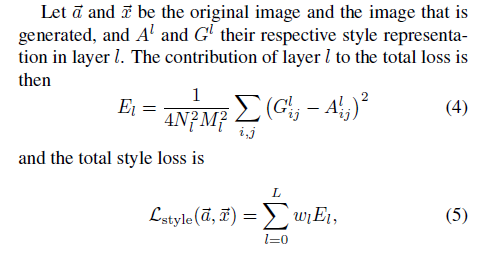

In [37]:
def build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]

    current_set_of_feature_maps = neural_net(optimizing_img)

    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)

    style_loss = 0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)

    tv_loss = total_variation(optimizing_img)

    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss

    return total_loss, content_loss, style_loss, tv_loss

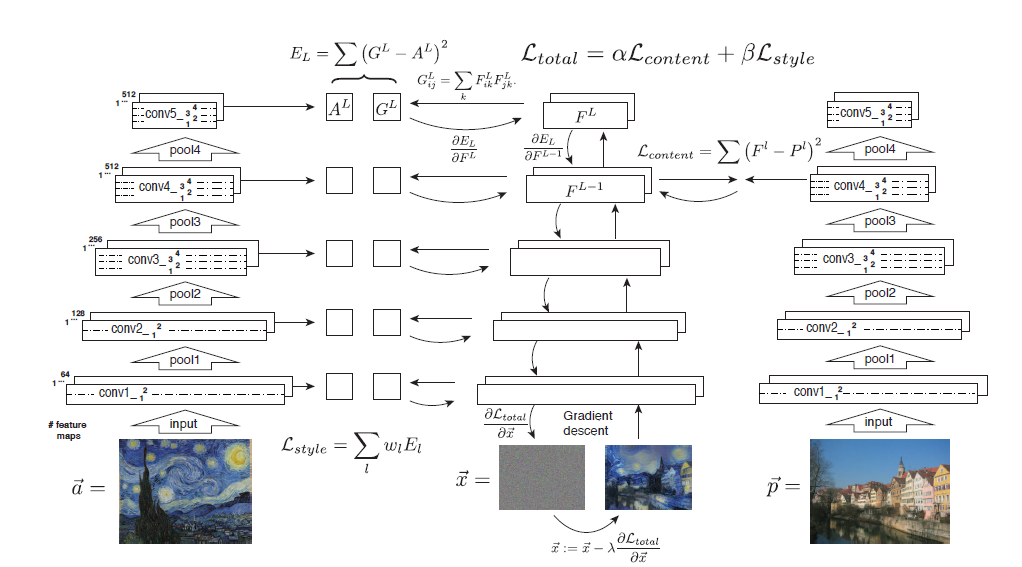

In [38]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the height
            current_height, current_width = img.shape[:2]
            new_height = target_shape
            new_width = int(current_width * (new_height / current_height))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # this need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img

In [39]:
def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

In [40]:
IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
IMAGENET_STD_NEUTRAL = [1, 1, 1]


In [41]:
def prepare_img(img_path, target_shape, device):
    img = load_image(img_path, target_shape=target_shape)

    # normalize using ImageNet's mean
    # [0, 255] range worked much better for me than [0, 1] range (even though PyTorch models were trained on latter)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    img = transform(img).to(device).unsqueeze(0)

    return img

In [42]:
class Vgg19(torch.nn.Module):
    """
    Used in the original NST paper, only those layers are exposed which were used in the original paper

    'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1' were used for style representation
    'conv4_2' was used for content representation (although they did some experiments with conv2_2 and conv5_2)
    """
    def __init__(self, requires_grad=False, show_progress=False, use_relu=True):
        super().__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True, progress=show_progress).features
        if use_relu:  # use relu or as in original paper conv layers
            self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2', 'relu5_1']
            self.offset = 1
        else:
            self.layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']
            self.offset = 0
            
        self.content_feature_maps_index = 1  # conv4_2
        # all layers used for style representation except conv4_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))
        self.style_feature_maps_indices.remove(4)  # conv4_2

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        for x in range(1+self.offset):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(1+self.offset, 6+self.offset):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(6+self.offset, 11+self.offset):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(11+self.offset, 20+self.offset):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(20+self.offset, 22):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22, 29++self.offset):
            self.slice6.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out

In [43]:
def prepare_model(model, device):
    # we are not tuning model weights -> we are only tuning optimizing_img's pixels! (that's why requires_grad=False)
    
    model = Vgg19(requires_grad=False, show_progress=True)
    content_feature_maps_index = model.content_feature_maps_index
    style_feature_maps_indices = model.style_feature_maps_indices
    layer_names = model.layer_names

    content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
    style_fms_indices_names = (style_feature_maps_indices, layer_names)
    return model.to(device).eval(), content_fms_index_name, style_fms_indices_names

In [44]:
def neural_style_transfer(config):
    content_images_dir = os.path.join(os.path.abspath('data') , 'content-images')
    style_images_dir = os.path.join(os.path.abspath('data'), 'style-images')
    output_img_dir = os.path.join(os.path.abspath('data'), 'output-images')
    img_format = (4, '.jpg')  # saves images in the format: %04d.jpg

    content_img_path = os.path.join(content_images_dir, config['content_img_name'])
    style_img_path = os.path.join(style_images_dir,config['style_img_name'] )

    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + os.path.split(style_img_path)[1].split('.')[0]
    dump_path = os.path.join(output_img_dir, out_dir_name)
    os.makedirs(dump_path, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = prepare_img(content_img_path, 400, device)
    style_img = prepare_img(style_img_path, 400, device)

    init_img = content_img
    optimizing_img = Variable(init_img, requires_grad=True)

    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = prepare_model('vgg19', device)
    print(f'Using vgg19 in the optimization procedure.')

    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)

    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]

    num_of_iterations_lbfgs = 1000

    optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations_lbfgs, line_search_fn='strong_wolfe')
    cnt = 0

    def closure():
        nonlocal cnt
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
        if total_loss.requires_grad:
            total_loss.backward()
        with torch.no_grad():
            print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
            save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations_lbfgs, should_display=False)

        cnt += 1
        return total_loss

    optimizer.step(closure)

    return dump_path

In [46]:
if __name__ == "__main__":
    resource_path=os.path.abspath('data')
    content_image_dir=os.path.join(resource_path,'content-images')
    
    style_image_dir=os.path.join(resource_path,'style-images')
    
    output_image_dir=os.path.join(resource_path, 'output-images')
    
    optimization_config = {
        'img_format': (4, '.jpg'),
        'content_img_name': 'content_image_2.jpg',
        'style_img_name': 'style_example2.jpg',
        'height': 400,
        'content_weight': 1e5,
        'style_weight': 3e4,
        'tv_weight': 1e0,
        'optimizer': 'lbfgs',
        'model': 'vgg19',
        'init_method': 'content',
        'saving_freq': -1,
    }
    results_path = neural_style_transfer(optimization_config)
    
    
    

    
    

Using vgg19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=5120649068544.0000, content_loss=      0.0000, style loss=5120641920000.0000, tv loss=7284129.0000
L-BFGS | iteration: 001, total loss=5120647495680.0000, content_loss=      0.0002, style loss=5120640000000.0000, tv loss=7284129.0000
L-BFGS | iteration: 002, total loss=5120637534208.0000, content_loss=      0.0036, style loss=5120630400000.0000, tv loss=7284131.5000
L-BFGS | iteration: 003, total loss=5120627048448.0000, content_loss=      0.0127, style loss=5120619840000.0000, tv loss=7284135.0000
L-BFGS | iteration: 004, total loss=5120609222656.0000, content_loss=      0.0439, style loss=5120602080000.0000, tv loss=7284139.5000
L-BFGS | iteration: 005, total loss=5120428343296.0000, content_loss=      1.3218, style loss=5120421120000.0000, tv loss=7284189.0000
L-BFGS | iteration: 006, total loss=5118806720512.0000, content_loss=     92.0850, style loss=5118799200000.0000, tv loss=7284626.0000
L-BFGS | ite

L-BFGS | iteration: 060, total loss=108148957184.0000, content_loss=1426477441.4062, style loss=106705875000.0000, tv loss=16599554.0000
L-BFGS | iteration: 061, total loss=105293012992.0000, content_loss=1403206738.2812, style loss=103873365000.0000, tv loss=16440593.0000
L-BFGS | iteration: 062, total loss=102136119296.0000, content_loss=1445544921.8750, style loss=100673857500.0000, tv loss=16715941.0000
L-BFGS | iteration: 063, total loss=100022042624.0000, content_loss=1432174023.4375, style loss=98573212500.0000, tv loss=16653796.0000
L-BFGS | iteration: 064, total loss=98440830976.0000, content_loss=1420881347.6562, style loss=97003395000.0000, tv loss=16558906.0000
L-BFGS | iteration: 065, total loss=96089071616.0000, content_loss=1425015429.6875, style loss=94647405000.0000, tv loss=16657019.0000
L-BFGS | iteration: 066, total loss=92757123072.0000, content_loss=1440022363.2812, style loss=91300305000.0000, tv loss=16794326.0000
L-BFGS | iteration: 067, total loss=89872064512.

L-BFGS | iteration: 121, total loss=31491637248.0000, content_loss=1521342187.5000, style loss=29952438750.0000, tv loss=17855812.0000
L-BFGS | iteration: 122, total loss=31092289536.0000, content_loss=1523429589.8438, style loss=29551005000.0000, tv loss=17854896.0000
L-BFGS | iteration: 123, total loss=30859763712.0000, content_loss=1529813378.9062, style loss=29312019375.0000, tv loss=17931704.0000
L-BFGS | iteration: 124, total loss=30520205312.0000, content_loss=1527302539.0625, style loss=28975001250.0000, tv loss=17900794.0000
L-BFGS | iteration: 125, total loss=30194944000.0000, content_loss=1527428027.3438, style loss=28649613750.0000, tv loss=17903220.0000
L-BFGS | iteration: 126, total loss=29854111744.0000, content_loss=1526711230.4688, style loss=28309475625.0000, tv loss=17926260.0000
L-BFGS | iteration: 127, total loss=29485281280.0000, content_loss=1531430859.3750, style loss=27935904375.0000, tv loss=17946972.0000
L-BFGS | iteration: 128, total loss=29238495232.0000, c

L-BFGS | iteration: 182, total loss=18905886720.0000, content_loss=1571665527.3438, style loss=17315589375.0000, tv loss=18629740.0000
L-BFGS | iteration: 183, total loss=18769481728.0000, content_loss=1573055859.3750, style loss=17177771250.0000, tv loss=18655936.0000
L-BFGS | iteration: 184, total loss=18601109504.0000, content_loss=1574913378.9062, style loss=17007513750.0000, tv loss=18681232.0000
L-BFGS | iteration: 185, total loss=18473158656.0000, content_loss=1574555761.7188, style loss=16879908750.0000, tv loss=18694794.0000
L-BFGS | iteration: 186, total loss=18359158784.0000, content_loss=1575509765.6250, style loss=16764950625.0000, tv loss=18697324.0000
L-BFGS | iteration: 187, total loss=18397415424.0000, content_loss=1576849511.7188, style loss=16801816875.0000, tv loss=18750012.0000
L-BFGS | iteration: 188, total loss=18305243136.0000, content_loss=1576224707.0312, style loss=16710296250.0000, tv loss=18721332.0000
L-BFGS | iteration: 189, total loss=18233972736.0000, c

L-BFGS | iteration: 243, total loss=14190397440.0000, content_loss=1609524414.0625, style loss=12561284062.5000, tv loss=19589452.0000
L-BFGS | iteration: 244, total loss=14105978880.0000, content_loss=1609852929.6875, style loss=12476520937.5000, tv loss=19605496.0000
L-BFGS | iteration: 245, total loss=14074096640.0000, content_loss=1610481152.3438, style loss=12443976562.5000, tv loss=19639566.0000
L-BFGS | iteration: 246, total loss=14006959104.0000, content_loss=1610899511.7188, style loss=12376427812.5000, tv loss=19631696.0000
L-BFGS | iteration: 247, total loss=13964820480.0000, content_loss=1611113574.2188, style loss=12334060312.5000, tv loss=19646292.0000
L-BFGS | iteration: 248, total loss=13924702208.0000, content_loss=1611269921.8750, style loss=12293775000.0000, tv loss=19656808.0000
L-BFGS | iteration: 249, total loss=13856587776.0000, content_loss=1612234765.6250, style loss=12224663437.5000, tv loss=19689716.0000
L-BFGS | iteration: 250, total loss=13794384896.0000, c

L-BFGS | iteration: 304, total loss=11692319744.0000, content_loss=1634733300.7812, style loss=10037072812.5000, tv loss=20513880.0000
L-BFGS | iteration: 305, total loss=11650290688.0000, content_loss=1634922753.9062, style loss=9994839375.0000, tv loss=20528646.0000
L-BFGS | iteration: 306, total loss=11602605056.0000, content_loss=1636341601.5625, style loss=9945697500.0000, tv loss=20566238.0000
L-BFGS | iteration: 307, total loss=11567338496.0000, content_loss=1635271875.0000, style loss=9911510625.0000, tv loss=20555848.0000
L-BFGS | iteration: 308, total loss=11543663616.0000, content_loss=1636155957.0312, style loss=9886934062.5000, tv loss=20573504.0000
L-BFGS | iteration: 309, total loss=11519240192.0000, content_loss=1637091015.6250, style loss=9861538125.0000, tv loss=20611432.0000
L-BFGS | iteration: 310, total loss=11496463360.0000, content_loss=1637706738.2812, style loss=9838149375.0000, tv loss=20607084.0000
L-BFGS | iteration: 311, total loss=11474098176.0000, content

L-BFGS | iteration: 366, total loss=10129519616.0000, content_loss=1653645117.1875, style loss=8454495937.5000, tv loss=21379036.0000
L-BFGS | iteration: 367, total loss=10097933312.0000, content_loss=1654084179.6875, style loss=8422445625.0000, tv loss=21403372.0000
L-BFGS | iteration: 368, total loss=10070268928.0000, content_loss=1654275585.9375, style loss=8394574687.5000, tv loss=21419028.0000
L-BFGS | iteration: 369, total loss=10047878144.0000, content_loss=1654590820.3125, style loss=8371861875.0000, tv loss=21424822.0000
L-BFGS | iteration: 370, total loss=10045619200.0000, content_loss=1655169335.9375, style loss=8368983750.0000, tv loss=21466120.0000
L-BFGS | iteration: 371, total loss=10037916672.0000, content_loss=1654934960.9375, style loss=8361534375.0000, tv loss=21447856.0000
L-BFGS | iteration: 372, total loss=10024058880.0000, content_loss=1655260546.8750, style loss=8347342500.0000, tv loss=21455854.0000
L-BFGS | iteration: 373, total loss=9994099712.0000, content_l

L-BFGS | iteration: 428, total loss=9078678528.0000, content_loss=1667611523.4375, style loss=7388922656.2500, tv loss=22143720.0000
L-BFGS | iteration: 429, total loss=9069087744.0000, content_loss=1667339062.5000, style loss=7379605312.5000, tv loss=22143348.0000
L-BFGS | iteration: 430, total loss=9061237760.0000, content_loss=1667387695.3125, style loss=7371705937.5000, tv loss=22144250.0000
L-BFGS | iteration: 431, total loss=9045874688.0000, content_loss=1667643164.0625, style loss=7356073593.7500, tv loss=22158260.0000
L-BFGS | iteration: 432, total loss=9027008512.0000, content_loss=1668026562.5000, style loss=7336815000.0000, tv loss=22166496.0000
L-BFGS | iteration: 433, total loss=9015339008.0000, content_loss=1668223242.1875, style loss=7324928906.2500, tv loss=22186952.0000
L-BFGS | iteration: 434, total loss=8999414784.0000, content_loss=1668603710.9375, style loss=7308615000.0000, tv loss=22196354.0000
L-BFGS | iteration: 435, total loss=8988571648.0000, content_loss=166

L-BFGS | iteration: 490, total loss=8341977600.0000, content_loss=1676636914.0625, style loss=6642576093.7500, tv loss=22765116.0000
L-BFGS | iteration: 491, total loss=8325710336.0000, content_loss=1676697851.5625, style loss=6626238750.0000, tv loss=22773006.0000
L-BFGS | iteration: 492, total loss=8317219328.0000, content_loss=1677093750.0000, style loss=6617324062.5000, tv loss=22801492.0000
L-BFGS | iteration: 493, total loss=8307108864.0000, content_loss=1677227343.7500, style loss=6607086562.5000, tv loss=22794952.0000
L-BFGS | iteration: 494, total loss=8300217856.0000, content_loss=1677012304.6875, style loss=6600408750.0000, tv loss=22796884.0000
L-BFGS | iteration: 495, total loss=8292868608.0000, content_loss=1677012695.3125, style loss=6593048906.2500, tv loss=22806896.0000
L-BFGS | iteration: 496, total loss=8283887616.0000, content_loss=1677063671.8750, style loss=6584010000.0000, tv loss=22813884.0000
L-BFGS | iteration: 497, total loss=8270487040.0000, content_loss=167

L-BFGS | iteration: 552, total loss=7814352384.0000, content_loss=1682915429.6875, style loss=6108167812.5000, tv loss=23269368.0000
L-BFGS | iteration: 553, total loss=7805732864.0000, content_loss=1682984375.0000, style loss=6099469687.5000, tv loss=23278584.0000
L-BFGS | iteration: 554, total loss=7796474368.0000, content_loss=1683034179.6875, style loss=6090154218.7500, tv loss=23286412.0000
L-BFGS | iteration: 555, total loss=7787237888.0000, content_loss=1683248242.1875, style loss=6080695312.5000, tv loss=23294332.0000
L-BFGS | iteration: 556, total loss=7779340288.0000, content_loss=1683363085.9375, style loss=6072674062.5000, tv loss=23303192.0000
L-BFGS | iteration: 557, total loss=7771356160.0000, content_loss=1683385156.2500, style loss=6064666406.2500, tv loss=23303960.0000
L-BFGS | iteration: 558, total loss=7772712448.0000, content_loss=1683602929.6875, style loss=6065778281.2500, tv loss=23331580.0000
L-BFGS | iteration: 559, total loss=7766888960.0000, content_loss=168

L-BFGS | iteration: 614, total loss=7391360512.0000, content_loss=1686871484.3750, style loss=5680782187.5000, tv loss=23706690.0000
L-BFGS | iteration: 615, total loss=7385558016.0000, content_loss=1686685546.8750, style loss=5675154843.7500, tv loss=23717552.0000
L-BFGS | iteration: 616, total loss=7380282880.0000, content_loss=1686719921.8750, style loss=5669852343.7500, tv loss=23710710.0000
L-BFGS | iteration: 617, total loss=7376680448.0000, content_loss=1686892382.8125, style loss=5666068593.7500, tv loss=23719426.0000
L-BFGS | iteration: 618, total loss=7370572288.0000, content_loss=1686889453.1250, style loss=5659952343.7500, tv loss=23730618.0000
L-BFGS | iteration: 619, total loss=7366090752.0000, content_loss=1687041601.5625, style loss=5655315468.7500, tv loss=23733696.0000
L-BFGS | iteration: 620, total loss=7359565312.0000, content_loss=1686918554.6875, style loss=5648909062.5000, tv loss=23737396.0000
L-BFGS | iteration: 621, total loss=7351751168.0000, content_loss=168

L-BFGS | iteration: 676, total loss=7059138560.0000, content_loss=1689295507.8125, style loss=5345750156.2500, tv loss=24092938.0000
L-BFGS | iteration: 677, total loss=7053562368.0000, content_loss=1689490429.6875, style loss=5339982656.2500, tv loss=24089150.0000
L-BFGS | iteration: 678, total loss=7051305472.0000, content_loss=1689502539.0625, style loss=5337711562.5000, tv loss=24091156.0000
L-BFGS | iteration: 679, total loss=7046499328.0000, content_loss=1689554101.5625, style loss=5332840312.5000, tv loss=24105020.0000
L-BFGS | iteration: 680, total loss=7042603008.0000, content_loss=1689592578.1250, style loss=5328906562.5000, tv loss=24103854.0000
L-BFGS | iteration: 681, total loss=7037770752.0000, content_loss=1689549218.7500, style loss=5324112187.5000, tv loss=24108948.0000
L-BFGS | iteration: 682, total loss=7030963200.0000, content_loss=1689508398.4375, style loss=5317338281.2500, tv loss=24116542.0000
L-BFGS | iteration: 683, total loss=7025010688.0000, content_loss=168

L-BFGS | iteration: 738, total loss=6793951744.0000, content_loss=1691110156.2500, style loss=5078416406.2500, tv loss=24425204.0000
L-BFGS | iteration: 739, total loss=6790038016.0000, content_loss=1691072070.3125, style loss=5074544062.5000, tv loss=24422052.0000
L-BFGS | iteration: 740, total loss=6786360320.0000, content_loss=1691070703.1250, style loss=5070864843.7500, tv loss=24424538.0000
L-BFGS | iteration: 741, total loss=6781932544.0000, content_loss=1691178125.0000, style loss=5066321250.0000, tv loss=24433380.0000
L-BFGS | iteration: 742, total loss=6776554496.0000, content_loss=1691269140.6250, style loss=5060839687.5000, tv loss=24445340.0000
L-BFGS | iteration: 743, total loss=6772055552.0000, content_loss=1691351171.8750, style loss=5056257187.5000, tv loss=24447548.0000
L-BFGS | iteration: 744, total loss=6769882624.0000, content_loss=1691238671.8750, style loss=5054190937.5000, tv loss=24452516.0000
L-BFGS | iteration: 745, total loss=6766706688.0000, content_loss=169

L-BFGS | iteration: 800, total loss=6571219968.0000, content_loss=1691685937.5000, style loss=4854823593.7500, tv loss=24710648.0000
L-BFGS | iteration: 801, total loss=6567507456.0000, content_loss=1691704882.8125, style loss=4851090000.0000, tv loss=24712556.0000
L-BFGS | iteration: 802, total loss=6563830272.0000, content_loss=1691653125.0000, style loss=4847460468.7500, tv loss=24716686.0000
L-BFGS | iteration: 803, total loss=6559950848.0000, content_loss=1691588476.5625, style loss=4843645312.5000, tv loss=24716886.0000
L-BFGS | iteration: 804, total loss=6556308992.0000, content_loss=1691696289.0625, style loss=4839885937.5000, tv loss=24727166.0000
L-BFGS | iteration: 805, total loss=6552164864.0000, content_loss=1691627148.4375, style loss=4835807812.5000, tv loss=24730016.0000
L-BFGS | iteration: 806, total loss=6549037056.0000, content_loss=1691706054.6875, style loss=4832597343.7500, tv loss=24733824.0000
L-BFGS | iteration: 807, total loss=6546785280.0000, content_loss=169

L-BFGS | iteration: 862, total loss=6378504192.0000, content_loss=1691269921.8750, style loss=4662275156.2500, tv loss=24958836.0000
L-BFGS | iteration: 863, total loss=6376735744.0000, content_loss=1691341406.2500, style loss=4660432500.0000, tv loss=24962144.0000
L-BFGS | iteration: 864, total loss=6374014976.0000, content_loss=1691315820.3125, style loss=4657732031.2500, tv loss=24967288.0000
L-BFGS | iteration: 865, total loss=6370599424.0000, content_loss=1691347460.9375, style loss=4654278750.0000, tv loss=24973318.0000
L-BFGS | iteration: 866, total loss=6366779904.0000, content_loss=1691231445.3125, style loss=4650573281.2500, tv loss=24974888.0000
L-BFGS | iteration: 867, total loss=6363661312.0000, content_loss=1691308203.1250, style loss=4647373593.7500, tv loss=24979712.0000
L-BFGS | iteration: 868, total loss=6361500672.0000, content_loss=1691202734.3750, style loss=4645315781.2500, tv loss=24982384.0000
L-BFGS | iteration: 869, total loss=6358569984.0000, content_loss=169

L-BFGS | iteration: 924, total loss=6218430976.0000, content_loss=1690536132.8125, style loss=4502723437.5000, tv loss=25171612.0000
L-BFGS | iteration: 925, total loss=6216201216.0000, content_loss=1690526562.5000, style loss=4500495937.5000, tv loss=25178752.0000
L-BFGS | iteration: 926, total loss=6213883392.0000, content_loss=1690580664.0625, style loss=4498125468.7500, tv loss=25177822.0000
L-BFGS | iteration: 927, total loss=6211954688.0000, content_loss=1690521484.3750, style loss=4496252343.7500, tv loss=25180596.0000
L-BFGS | iteration: 928, total loss=6209568256.0000, content_loss=1690556640.6250, style loss=4493826562.5000, tv loss=25184744.0000
L-BFGS | iteration: 929, total loss=6206930944.0000, content_loss=1690537304.6875, style loss=4491205312.5000, tv loss=25188504.0000
L-BFGS | iteration: 930, total loss=6203532800.0000, content_loss=1690592187.5000, style loss=4487747812.5000, tv loss=25193078.0000
L-BFGS | iteration: 931, total loss=6200941568.0000, content_loss=169

L-BFGS | iteration: 986, total loss=6076749824.0000, content_loss=1690326562.5000, style loss=4361048437.5000, tv loss=25374940.0000
L-BFGS | iteration: 987, total loss=6074877440.0000, content_loss=1690283203.1250, style loss=4359214687.5000, tv loss=25379268.0000
L-BFGS | iteration: 988, total loss=6072417280.0000, content_loss=1690360546.8750, style loss=4356672656.2500, tv loss=25383986.0000
L-BFGS | iteration: 989, total loss=6070405632.0000, content_loss=1690269335.9375, style loss=4354748906.2500, tv loss=25387736.0000
L-BFGS | iteration: 990, total loss=6068292608.0000, content_loss=1690318750.0000, style loss=4352585625.0000, tv loss=25387808.0000
L-BFGS | iteration: 991, total loss=6066656768.0000, content_loss=1690346484.3750, style loss=4350917343.7500, tv loss=25393378.0000
L-BFGS | iteration: 992, total loss=6064793600.0000, content_loss=1690290234.3750, style loss=4349110781.2500, tv loss=25392536.0000
L-BFGS | iteration: 993, total loss=6062228992.0000, content_loss=169